In [1]:
"""Initial analysis of shap values behavior."""
# pylint: disable=redefined-outer-name, expression-not-assigned, import-error, not-callable, pointless-statement
from pathlib import Path

import numpy as np
import plotly.express as plt
import plotly.io as pio
import shap
from IPython import display

pio.renderers.default = "notebook"

from src.python.core import metadata
from src.python.core.analysis import SHAP_Handler
from src.python.core.model_pytorch import LightningDenseClassifier

In [ ]:
%matplotlib inline

In [2]:
home = Path("/home/local/USHERBROOKE/rabj2301/Projects")
input_dir = home / "epilap/input"
metadata_path = input_dir / "metadata/merge_EpiAtlas_allmetadata-v11-mod.json"

output = home / "epilap/output"
logdir = output / "logs/hg38_2022-epiatlas/shap"
model_dir = output / "models/split0"

my_meta = metadata.Metadata(metadata_path)
target_mapping = LightningDenseClassifier.restore_model(model_dir).mapping

Reading checkpoint list and taking last line.
Loading model from /home/local/USHERBROOKE/rabj2301/Projects/epilap/output/models/split0/EpiLaP/41b81b0eeb4b4a048625a31458f1f199/checkpoints/epoch=87-step=88.ckpt


In [18]:
my_meta.remove_category_subsets("track_type", ["raw", "fc", "Unique_raw"])
# len(my_meta)
my_meta.remove_small_classes(10, "assay")
my_meta.display_labels("assay")
my_meta.display_labels("track_type")

0 labels missing and ignored from count
10/10 labels left from assay after removing classes with less than 10 signals.

Label breakdown for assay
0 labels missing and ignored from count
rna_seq: 2356
h3k27ac: 1542
wgbs: 1290
h3k4me1: 934
input: 902
h3k4me3: 746
h3k36me3: 669
h3k27me3: 651
h3k9me3: 637
mrna_seq: 568
For a total of 10295 examples


Label breakdown for track_type
0 labels missing and ignored from count
pval: 5179
Unique_minusRaw: 1462
Unique_plusRaw: 1462
ctl_raw: 902
gembs_neg: 645
gembs_pos: 645
For a total of 10295 examples



In [3]:
display(target_mapping)
classes = target_mapping.values()
print(classes, list(classes))

{0: 'h3k27ac',
 1: 'h3k27me3',
 2: 'h3k36me3',
 3: 'h3k4me1',
 4: 'h3k4me3',
 5: 'h3k9me3',
 6: 'input',
 7: 'mrna_seq',
 8: 'rna_seq',
 9: 'wgbs'}

dict_values(['h3k27ac', 'h3k27me3', 'h3k36me3', 'h3k4me1', 'h3k4me3', 'h3k9me3', 'input', 'mrna_seq', 'rna_seq', 'wgbs']) ['h3k27ac', 'h3k27me3', 'h3k36me3', 'h3k4me1', 'h3k4me3', 'h3k9me3', 'input', 'mrna_seq', 'rna_seq', 'wgbs']


In [4]:
eval_shaps_1 = SHAP_Handler.load_from_pickle(
    path=str(logdir / "shap_values_background_effect_test_2022-12-12_18-54-39.pickle")
)
eval_shaps_2 = SHAP_Handler.load_from_pickle(
    path=str(logdir / "shap_values_background_effect_test_2022-12-12_18-57-56.pickle")
)

In [3]:
eval_shaps_1.keys()

dict_keys(['shap', 'ids'])

In [4]:
labels = [my_meta[md5]["assay"] for md5 in eval_shaps_1["ids"]]
print(labels[0:-1:5])

['rna_seq', 'rna_seq', 'h3k9me3', 'h3k9me3', 'h3k36me3', 'h3k36me3']


In [9]:
eval_shaps_1["shap"][0].shape

(30, 30321)

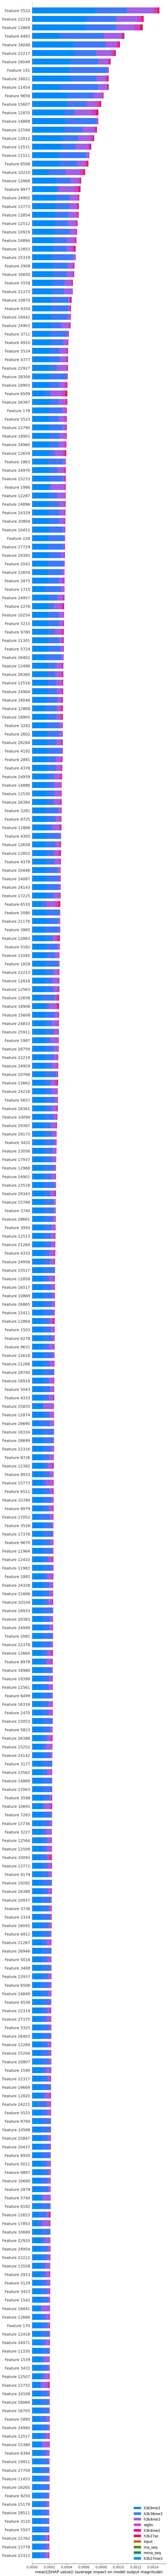

In [25]:

shap.summary_plot(eval_shaps_1["shap"], max_display=300, class_names=list(classes))

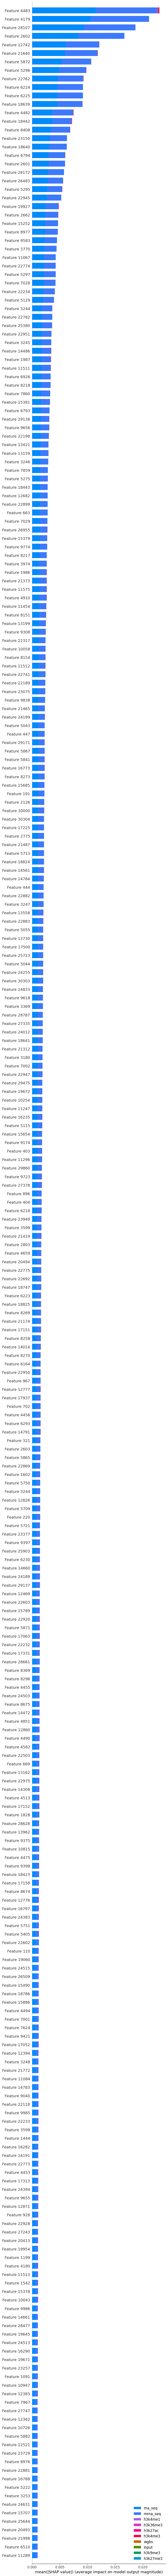

In [29]:
shap.summary_plot(eval_shaps_2["shap"], max_display=300, class_names=list(classes))

In [5]:
def average_impact(shap_values_matrices):
    """Return average absolute shap values."""
    shap_abs = np.zeros(shap_values_matrices[0].shape)
    for matrix in shap_values_matrices:
        shap_abs += np.absolute(matrix)
    shap_abs / len(shap_values_matrices)
    return shap_abs

In [6]:
def n_most_important_features(sample_shaps, n):
    """Return features with highest shap values."""
    avg_shaps = sample_shaps.sum(axis=0)
    return np.flip(np.argsort(avg_shaps))[:n]

In [13]:
total_avg_1 = average_impact(eval_shaps_1["shap"])
total_avg_2 = average_impact(eval_shaps_2["shap"])

n = 1000
most_important_features = set(n_most_important_features(total_avg_1, n)) & set(
    n_most_important_features(total_avg_2, n)
)
print(len(most_important_features))

243


In [8]:
print(classes)
for i, (matrix1, matrix2) in enumerate(zip(eval_shaps_1["shap"], eval_shaps_2["shap"])):
    most_important_class_features = set(n_most_important_features(matrix1, 100)) & set(
        n_most_important_features(matrix2, 100)
    )
    print(i, len(most_important_class_features))

dict_values(['h3k27ac', 'h3k27me3', 'h3k36me3', 'h3k4me1', 'h3k4me3', 'h3k9me3', 'input', 'mrna_seq', 'rna_seq', 'wgbs'])
0 1
1 5
2 6
3 4
4 12
5 18
6 14
7 3
8 4
9 6


In [9]:
def box_plot(avg_impact):
    """Print a box plot"""
    plt.box(y=avg_impact.sum(axis=0)).show()

In [11]:
box_plot(total_avg_1)
box_plot(total_avg_2)